# SyriaTel Customer Churn Project

### Team Members
    * Eddie Lin
    * Tony Bai
    * Douglas Lu
    * Arthur Kim

## Imports

In [1]:
#import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xg
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,log_loss, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from imblearn.over_sampling import SMOTE, SMOTENC

import warnings


In [2]:
warnings.filterwarnings("ignore")

## Data Manipulation

In [3]:
#load the data

df = pd.read_csv('data/syrialtel_cleaned_data.csv')

In [4]:
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_calls,total_charge,charge_per_min_day,charge_per_min_eve,charge_per_min_night,charge_per_min_dom,charge_per_min_int,%_int_min,call_satisfaction,region
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,303,75.56,0.409727,0.169495,0.120989,0.242867,0.900000,1.394311,0.330033,Midwest
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,...,332,59.24,0.223333,0.161359,0.111165,0.168815,1.233333,2.191299,0.301205,Midwest
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,...,333,62.29,0.362982,0.093636,0.070385,0.179878,0.658000,2.261772,0.000000,Northeast
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,...,255,66.80,0.716901,0.059773,0.099551,0.262177,0.254286,1.168555,0.784314,Midwest
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,...,359,52.09,0.250796,0.103361,0.069504,0.138652,0.910000,1.972656,0.835655,South


In [5]:
df['churn'].value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [6]:
df['total_charge'].sum()

198146.03000000003

The data is split to a train and test data

In [7]:
#seperating the target and data
X = df.drop('churn', axis=1)
y = df['churn']

#creating a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Splitting the data between categorical and continuous

In [8]:
categorical = ['state','area_code', 'international_plan', 'voice_mail_plan', 'region']
df_cat = X_train[categorical]
df_cont = X_train.drop(categorical,axis = 1)

In [9]:
#splitting the numericals and categoricals
X_num = df_cont.columns
X_cat = df_cat.columns

## Pipeline

In [10]:
#preprocessing the pipeline with standard scaler and one hot encoder
numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                          sparse=False))
    ])

pp = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
    ])

In [11]:
# transform the pipeline and then converting it back into a dataframe
X_train_scaled = pp.fit_transform(X_train)
X_test_scaled = pp.transform(X_test)

In [12]:
# aggregating col names from the one hot encode 
cat_names = pp.transformers_[1][1].named_steps['ohe'].get_feature_names(X_cat).tolist()
feature_names= list(X_num) + cat_names

# renaming the data frame with corresponding col names
X_train_scaled = pd.DataFrame(X_train_scaled, columns = feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

In [13]:
feature_names

['account_length',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'customer_service_calls',
 'total_minutes_dom',
 'total_calls_dom',
 'total_charge_dom',
 'total_minutes',
 'total_calls',
 'total_charge',
 'charge_per_min_day',
 'charge_per_min_eve',
 'charge_per_min_night',
 'charge_per_min_dom',
 'charge_per_min_int',
 '%_int_min',
 'call_satisfaction',
 'state_AL',
 'state_AR',
 'state_AZ',
 'state_CA',
 'state_CO',
 'state_CT',
 'state_DC',
 'state_DE',
 'state_FL',
 'state_GA',
 'state_HI',
 'state_IA',
 'state_ID',
 'state_IL',
 'state_IN',
 'state_KS',
 'state_KY',
 'state_LA',
 'state_MA',
 'state_MD',
 'state_ME',
 'state_MI',
 'state_MN',
 'state_MO',
 'state_MS',
 'state_MT',
 'state_NC',
 'state_ND',
 'state_NE',
 'state_NH',
 'state_NJ

# Functions

In [14]:
def scores(model, actual = y_test ,X_train_scaled = X_train_scaled, X_test_scaled = X_test_scaled,y_train = y_train):
    pred_train = model.predict(X_train_scaled)
    pred_test = model.predict(X_test_scaled)
    
    plot_confusion_matrix(model, X_train_scaled, y_train)
    print("Train Scores")
    print("log loss: ", log_loss(y_train, pred_train))
    print("accuracy: ", accuracy_score(y_train, pred_train))
    print("precision:", precision_score(y_train, pred_train))
    print("recall:   ", recall_score(y_train, pred_train))
    
    
    print("Test Scores")
    print("log loss: ", log_loss(actual, pred_test))
    print("accuracy: ", accuracy_score(actual, pred_test))
    print("precision:", precision_score(actual, pred_test))
    print("recall:   ", recall_score(actual, pred_test))
    
    
    plot_confusion_matrix(model, X_test_scaled, actual)

In [15]:
def plot_feature_importances(model):
    n_features = X_train_scaled.shape[1]
    plt.figure(figsize=(8,20))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_scaled.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

# Dummy model

Train Scores
log loss:  5.033512205001985
accuracy:  0.8542648949849978
precision: 0.0
recall:    0.0
Test Scores
log loss:  4.939045024472227
accuracy:  0.857
precision: 0.0
recall:    0.0


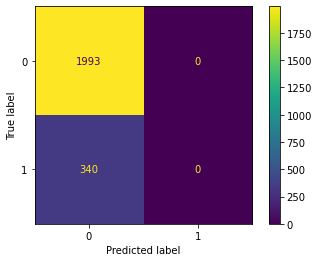

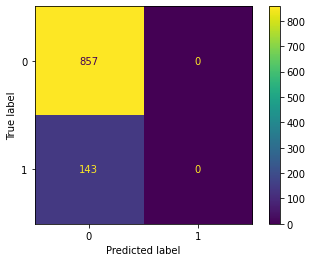

In [16]:
##We create a dummy model of our data
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_scaled, y_train)

#y_preds_dum= dummy_clf.predict(X_test)

scores(dummy_clf);

#from this data we can see that the data is skewed
#and has a 85% accuracy of predicting correctly when 
#assuming one category

## Model 1:  Log Regression

In [17]:
## Here we use a basic Log Regresion used a baseline log regression model to test out the data


logreg = LogisticRegression(random_state=42, max_iter=2000)#look into warning

logreg.fit(X_train_scaled, y_train)

logreg_cv = cross_val_score(logreg, X_train_scaled, y_train).mean()
print(logreg_cv)

0.8636884138552169


Train Scores
log loss:  4.248891901939016
accuracy:  0.8769824260608658
precision: 0.6853146853146853
recall:    0.28823529411764703
Test Scores
log loss:  4.593675651264016
accuracy:  0.867
precision: 0.5892857142857143
recall:    0.23076923076923078


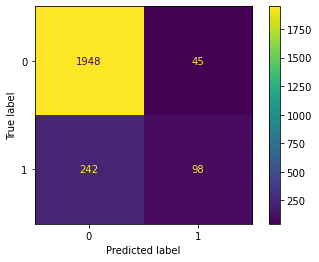

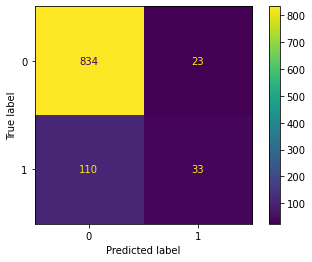

In [18]:
scores(logreg,y_test)

In [19]:
# print(logreg_baseline.score(X_train_scaled, y_train))
# print(logreg_baseline.score(X_test_scaled, y_test))

In [20]:
# y_preds_log = logreg_baseline.predict(X_test_scaled)
# scores(y_test,)

### Not terrible results for the first model

But we have decided to look at recall for our metric. As a telecom company trying to reduce churn, we care about the recall of our model. Recall is defined as the TP/(TP+FN). We are trying to minimize False Negatives (FN) here, meaning that we want to reduce the number of people that our model predicts will not churn but are actually likely to do so. This is because we want to send out promotions to retain customers and we do not want to miss any potential customers who are likely to churn.

## Model 2: K-Nearest Neighbors and Grid Search without SMOTE

The Gridsearch for the KNN model is commented out due to the long run time for the search. The best parameters from the search has been selected and assigned below.

In [21]:


### initate the model with no parameters

# knn_model = KNeighborsClassifier()


# # initiate grid and grid search
# param_grid = {
#     'n_neighbors': list(range(1, 20, 2)),
#     'weights': ['uniform', 'distance'],
#     'p': [1, 2, 3, 4],
# }


# gs_knn = GridSearchCV(knn_model, param_grid=param_grid, cv=5)
# gs_knn.fit(X_train_scaled, y_train)

# gs_knn.best_params_

In [22]:
best_knn = KNeighborsClassifier(n_neighbors = 7,
                                p = 1,
                                weights = 'uniform') 
best_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=7, p=1)

In [23]:
# y_train_preds = best_knn.predict(X_train_scaled)
# y_test_preds = best_knn.predict(X_test_scaled)

In [24]:
#best_knn.score(X_train_scaled, y_train)

Train Scores
log loss:  3.1977634368110373
accuracy:  0.9074153450492928
precision: 0.9428571428571428
recall:    0.38823529411764707
Test Scores
log loss:  3.4193404622910184
accuracy:  0.901
precision: 0.9583333333333334
recall:    0.32167832167832167


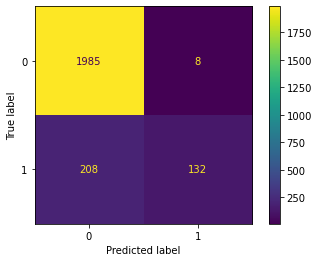

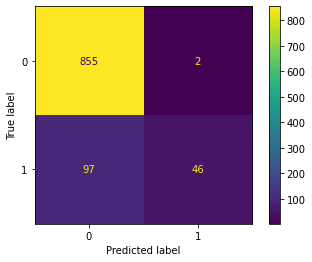

In [25]:
scores(best_knn,y_test)

In [26]:
# best_knn.score(X_test_scaled, y_test)

In [27]:
#print(classification_report(y_train, y_train_preds))

In [28]:
#print(classification_report(y_test, y_test_preds))

In [29]:
#print(confusion_matrix(y_train, y_train_preds))

In [30]:
#print(confusion_matrix(y_test, y_test_preds))

Our recall score came out too low and maybe this was caused because of a class imbalance. Now we will try to use SMOTE to reduce that

## Model 3: K-Nearest Neighbors and Grid Search with SMOTE

In [31]:
# calculate the current ratio of imbalance for SMOTE 
round(len(y_train[y_train==1])/len(y_train[y_train==0]),2)

0.17

In [32]:
# SMOTE the categorical columns by their index
cat_range = range(28,57)
smote = SMOTENC(np.array(cat_range),random_state=42, sampling_strategy=0.5)
# X_train_resampled, y_train_resampled = smote.fit_sample(X_traain_scaled, y_train)

In [33]:
# Rerun the KNN Model with SMOTED DATA

knn_model_smote = imbpipeline(steps=[
        ("Preprocess", pp),
        ('sampling', smote),
        ('knn', KNeighborsClassifier())
    ])


In [34]:
knn_model_smote.fit(X_train,y_train)

Pipeline(steps=[('Preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_int...
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['state', 'area_code', 'international_plan', 'voice_mail_plan',
       'region'],
      dtype='object'

In [35]:
# #perform a grid search again to see if criteria changed
# param_grid = {
#     'knn__n_neighbors': list(range(2, 100, 2)),
#     'knn__weights': ['uniform', 'distance'],
#     'knn__p': [1, 2, 3, 4],
# }

# gs_knn = GridSearchCV(knn_model_smote, param_grid, cv=2, scoring='recall')
# #gs_knn.fit(X_train, y_train_resampled)

# # gs_knn.best_params_

In [36]:
# gs_knn.fit(X_train, y_train)

# gs_knn.best_params_

The code above is a gridsearch for the KNN smote model. The gridsearch takes a long time to complete thus the best parameters have already been set below.

In [37]:
#best knn smote model obtained from the gridsearch above
best_knn_sm = KNeighborsClassifier(n_neighbors= 32, p = 2, weights= 'distance')

In [38]:
best_knn_sm.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=32, weights='distance')

Train Scores
log loss:  9.992007221626415e-16
accuracy:  1.0
precision: 1.0
recall:    1.0
Test Scores
log loss:  4.248270296171444
accuracy:  0.877
precision: 0.9545454545454546
recall:    0.14685314685314685


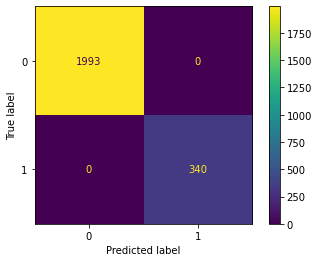

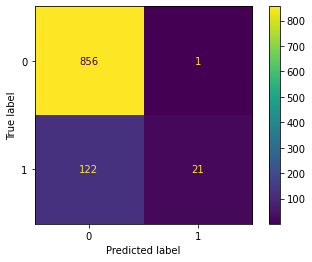

In [39]:
scores(best_knn_sm)

The SMOTE-NC KNN model is overfit. The accuracy is high on the trainning data, and the test set performs worse.

In [40]:
# gs_knn.score(X_train_scaled, y_train)

In [41]:
# gs_knn.score(X_test_scaled, y_test)

In [42]:
# y_train_preds = gs_knn.predict(X_train_scaled)
# y_test_preds = gs_knn.predict(X_test_scaled)

In [43]:
# print(classification_report(y_train, y_train_preds))

In [44]:
# print(classification_report(y_test, y_test_preds))

In [45]:
# print(confusion_matrix(y_test, y_test_preds))

After applying SMOTENC to the data, the recall score significantly improved.

## Decision Tree Model

The KNN Model with SMOTENC performed significantly better, however the recall score wasn't as high as we would like it. Here we run a Decision Tree model to see if we have a better fit.

In [46]:
#Instantiate a Decision Tree and perform 3-fold cross-validaiton on training data

DT_clf = DecisionTreeClassifier() 

DT_cv_score = cross_val_score(DT_clf, X_train_scaled, y_train, cv=3)

mean_DT_cv_score = np.mean(DT_cv_score)

print(f"Mean Cross Val Score: {mean_DT_cv_score:.2%}")

#Model performed much better than the baseline and slightly better accuracy than the KNN model

Mean Cross Val Score: 94.21%


Due to the long runtime of the the Decision Tree Gridsearch, the best selection from the following search was selected for further analysis.

In [47]:
#Create grid search parameters and intantiate GridSearch CV. Create different parameters and then fit the data. 

# DT_clf = DecisionTreeClassifier() 

# param_grid = { 
#     'criterion': ['gini', 'entropy'],
#     'max_depth': np.arange(1, 15, 2), #step up even higher 
#     'min_samples_split': np.arange(5, 120, 5),
#     'min_samples_leaf': np.arange(5, 120,5)
#     }

# gs_DT_clf = GridSearchCV(DT_clf, param_grid = param_grid, n_jobs = -1, scoring = "recall", cv = 5)

# gs_DT_clf.fit(X_train_scaled, y_train)
    
#SPECIFCY SCORING IN GRIDSEARCH TO RECALL? CURRENTLY ON ACCURACY: scoring = 'recall',  

#consistency in paramgrid search rationale 
#random CV search 

#After running it best parameter = 
# {'criterion': 'entropy',
#  'max_depth': 7,
#  'min_samples_leaf': 5,
#  'min_samples_split': 5}

In [48]:
best_DT_clf = DecisionTreeClassifier(criterion='entropy',
                                    max_depth= 7,
                                    min_samples_leaf= 5,
                                    min_samples_split= 5) 
best_DT_clf.fit(X_train_scaled, y_train)

# y_train_preds = best_DT_clf.predict(X_train_scaled)
# y_test_preds = best_DT_clf.predict(X_test_scaled)


DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=5,
                       min_samples_split=5)

Train Scores
log loss:  0.8438548876552214
accuracy:  0.9755679382768967
precision: 0.9862542955326461
recall:    0.8441176470588235
Test Scores
log loss:  0.5871599983109127
accuracy:  0.983
precision: 0.9921875
recall:    0.8881118881118881


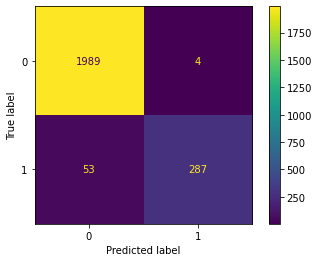

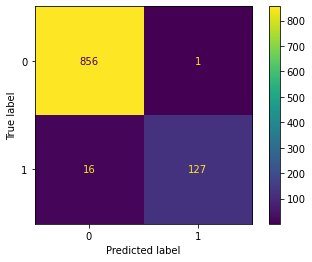

In [49]:
#print(classification_report(y_train, y_train_preds))
#print(classification_report(y_test, y_test_preds))
#print(confusion_matrix(y_test, y_test_preds))

scores(best_DT_clf)

We see here that the decision tree model also giving us high recall as that is the feature we want to focus on.

We will plot the important features and see what drives this model.

In [50]:
#best_DT_clf.feature_importances_

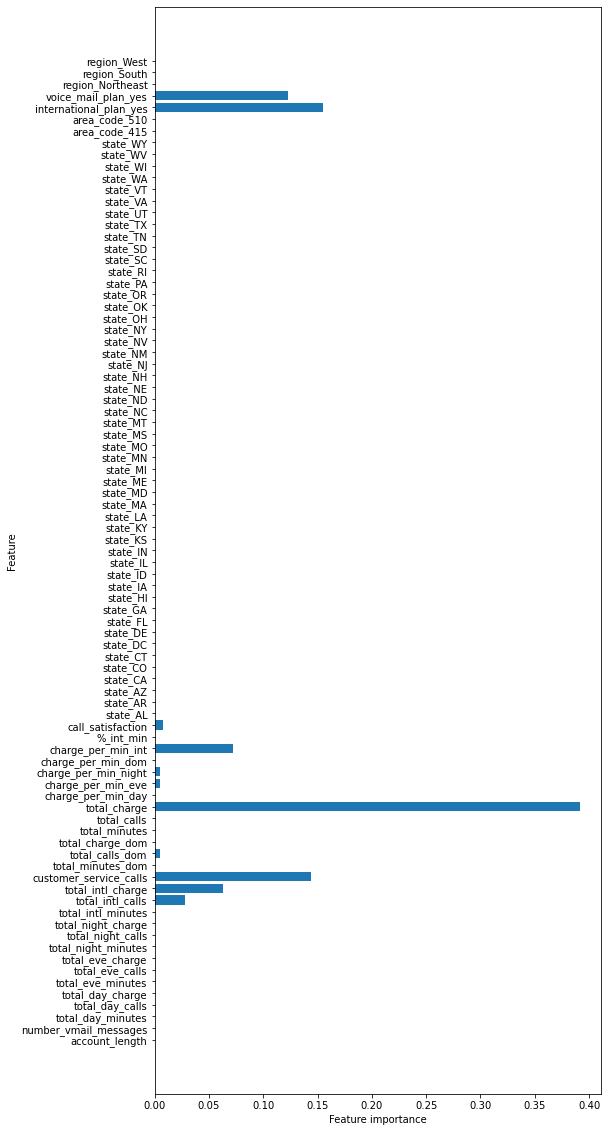

In [51]:
# def plot_feature_importances(model):
#     n_features = X_train_scaled.shape[1]
#     plt.figure(figsize=(8,20))
#     plt.barh(range(n_features), model.feature_importances_, align='center') 
#     plt.yticks(np.arange(n_features), X_train_scaled.columns.values) 
#     plt.xlabel('Feature importance')
#     plt.ylabel('Feature')

plot_feature_importances(best_DT_clf)

# Bagging Model

We also tested the bagging classifier model to see how this one stacks up to the other.

Train Scores
log loss:  0.9474846503533157
accuracy:  0.9725675096442349
precision: 1.0
recall:    0.8117647058823529
Test Scores
log loss:  0.6562367515033039
accuracy:  0.981
precision: 1.0
recall:    0.8671328671328671


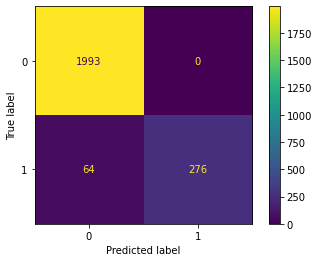

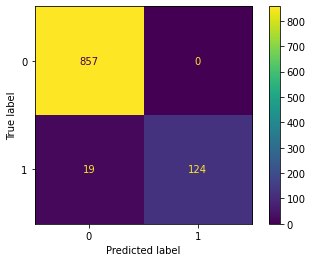

In [52]:
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion = 'entropy', 
                                                       max_depth = 5, 
                                                       min_samples_leaf = 10, 
                                                       min_samples_split = 3), 
                                                       n_estimators = 20)

#Fit the model on training data
bagged_tree.fit(X_train_scaled, y_train)
#Training accuracy score 
#bagged_tree.score(X_train_scaled, y_train)
#Test accuracy score
#bagged_tree.score(X_test_scaled, y_test)
scores(bagged_tree)


The data is pretty good with good accuracy with both the test and train data, but the recall on the test data performed worse.

# Random Forest

In [53]:
rf_model = RandomForestClassifier(criterion = 'entropy', 
                                  n_estimators = 1150, 
                                  max_depth=10, 
                                  bootstrap = True, 
                                  min_samples_split= 7)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=7,
                       n_estimators=1150)

Train Scores
log loss:  0.814244621397381
accuracy:  0.9764252036005143
precision: 1.0
recall:    0.8382352941176471
Test Scores
log loss:  1.4160898321913387
accuracy:  0.959
precision: 1.0
recall:    0.7132867132867133


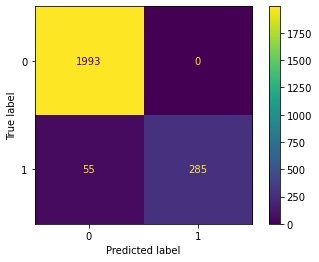

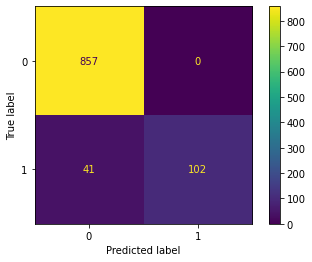

In [54]:
rf_preds = rf_model.predict(X_test_scaled)
scores(rf_model)

In [55]:
# # Grid Search for parameters, Played around with n_estimators before and found the optimal so excluded from this grid search
# grid = {        
#  'max_depth': [8,10],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 7]}

# gs = GridSearchCV(estimator=rf_model, param_grid= grid, cv=2)
# gs.fit(X_train_scaled, y_train)
# gs.best_params_

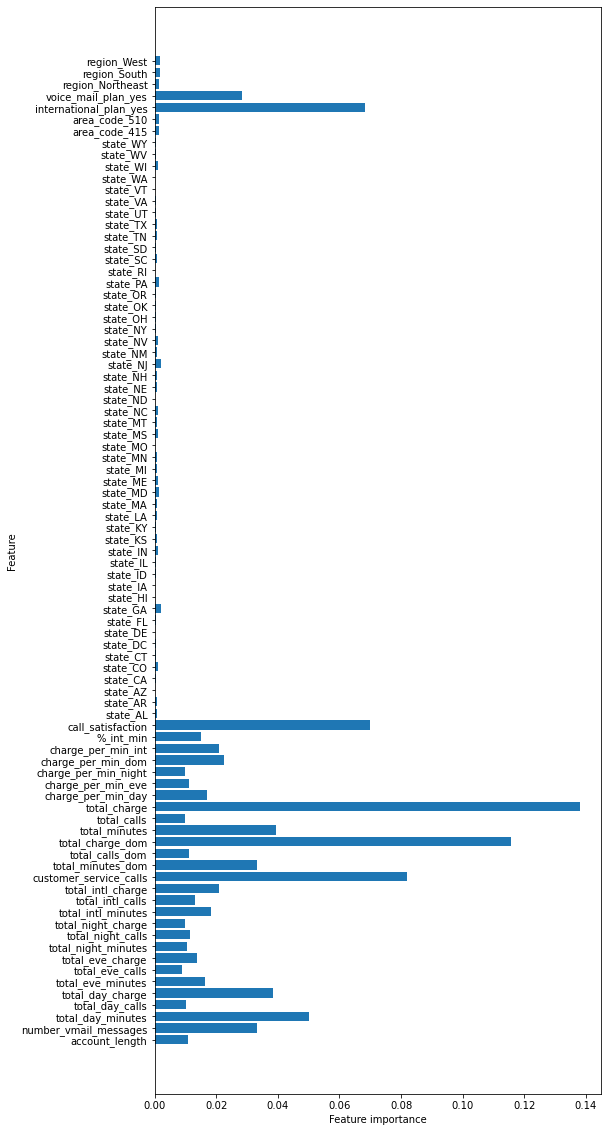

In [56]:

best_rf_model= RandomForestClassifier(max_depth = 10, 
                                   max_features = 'auto',
                                   min_samples_leaf = 1,
                                   min_samples_split = 5)
best_rf_model.fit(X_train_scaled,y_train)

plot_feature_importances(best_rf_model)

# best_param=[]
# for name, score in zip(X_train_scaled.columns, rf_model.feature_importances_):
    
#     best_param.append((name,score))
# best_param.sort(reverse= True, key=lambda x: x[1])
# best_param[:10]

# XGBoost

In [57]:
xgb_model= xg.XGBClassifier(random_state=42, objective='binary:logistic', alpha=2)

In [58]:
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(alpha=2, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=2, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Train Scores
log loss:  0.19245781960301805
accuracy:  0.9944277753964852
precision: 1.0
recall:    0.961764705882353
Test Scores
log loss:  0.5526204223185719
accuracy:  0.984
precision: 1.0
recall:    0.8881118881118881


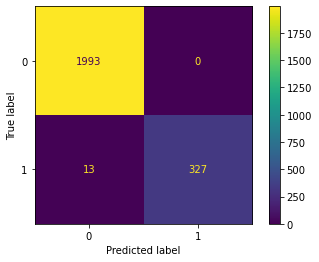

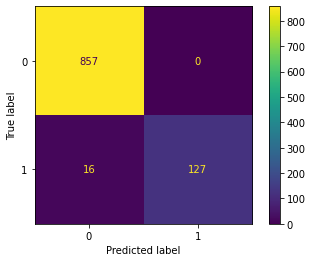

In [59]:
#y_preds_xgb = xgb_model.predict(X_test_scaled)
scores(xgb_model)

In [60]:
# grid2 = {'eta': [.05,.1, .2, .4],
#          'max_depth': [3,8,9],
#          'alpha' : [1,2,3,4]
#  }
# gs = GridSearchCV(estimator=xgb_model, param_grid= grid2, cv=2)
# gs.fit(X_train_scaled, y_train)
# gs.best_params_

In [61]:
best_xg_model = xg.XGBClassifier(alpha = 1, eta = 0.5, max_depth = 8)
best_xg_model.fit(X_train_scaled,y_train)

XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.5, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Train Scores
log loss:  9.992007221626415e-16
accuracy:  1.0
precision: 1.0
recall:    1.0
Test Scores
log loss:  0.5526204223185719
accuracy:  0.984
precision: 1.0
recall:    0.8881118881118881


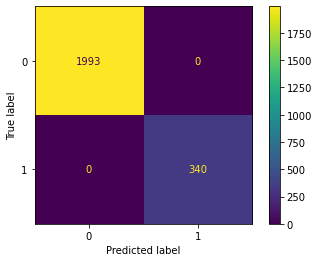

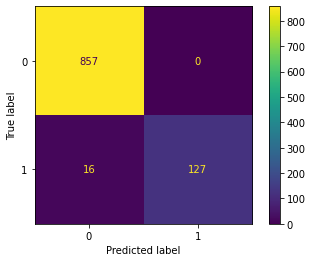

In [62]:
scores(best_xg_model)

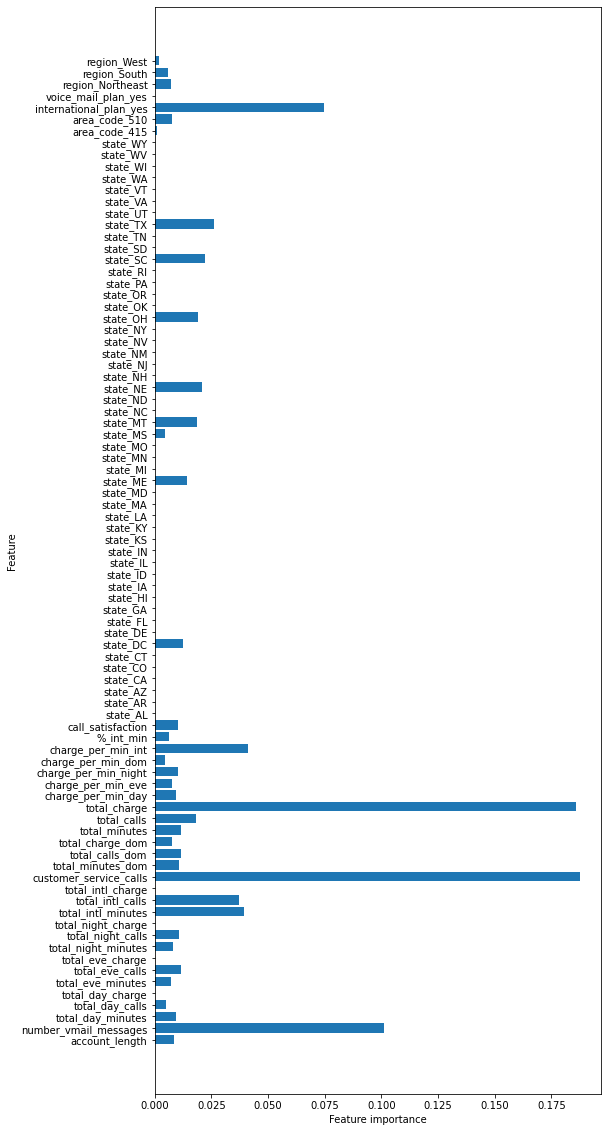

In [63]:
# from xgboost import plot_importance
# fit = xgb_model.fit(X_train_scaled, y_train)
# plot_importance(fit)

plot_feature_importances(best_xg_model)

Train Scores
log loss:  0.7402223830885283
accuracy:  0.9785683669095585
precision: 1.0
recall:    0.8529411764705882
Test Scores
log loss:  0.5526204223185719
accuracy:  0.984
precision: 1.0
recall:    0.8881118881118881


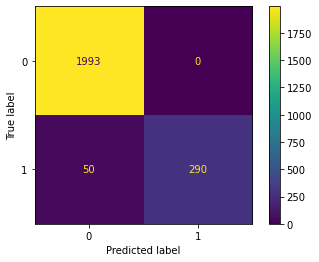

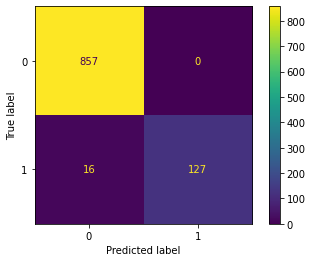

In [64]:
xgb_model= xg.XGBClassifier(random_state=42, objective='binary:hinge', alpha=1, eta =.05, max_depth =3)
xgb_model.fit(X_train_scaled, y_train)
y_preds_xgb = xgb_model.predict(X_test_scaled)
scores(xgb_model)

# AdaBoost

In [65]:
model_boost_ada = AdaBoostClassifier(n_estimators=40,random_state=42)
model_boost_ada.fit(X_train_scaled,y_train)
# model_boost_ada.predict(X_train_scaled)

# model_boost_ada.score(X_train_scaled,y_train)


AdaBoostClassifier(n_estimators=40, random_state=42)

Train Scores
log loss:  2.54637802170038
accuracy:  0.9262751821688813
precision: 0.8442622950819673
recall:    0.6058823529411764
Test Scores
log loss:  3.1430478422751973
accuracy:  0.909
precision: 0.76
recall:    0.5314685314685315


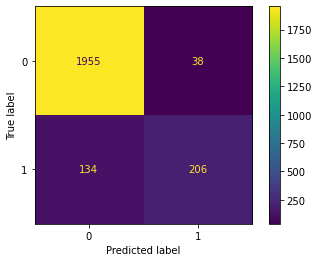

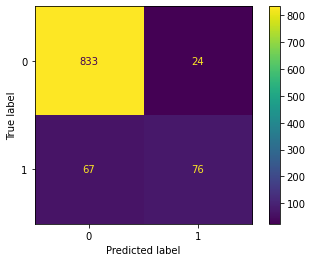

In [66]:
#y_preds= model_boost_ada.predict(X_test_scaled)
scores(model_boost_ada)

# Gradient Boost

In [67]:
model_boost_gb = GradientBoostingClassifier(random_state=42)
gb_m = model_boost_gb.fit(X_train_scaled,y_train)
#model_boost_gb.score(X_train_scaled,y_train)

In [68]:
gradient_boost_cv = cross_val_score(gb_m, X_train_scaled, y_train, cv = 10)
gradient_boost_cv
gradient_boost_cv.mean()

0.9772862330802244

Train Scores
log loss:  0.6217868017943637
accuracy:  0.9819974282040291
precision: 1.0
recall:    0.8764705882352941
Test Scores
log loss:  0.5526204223185719
accuracy:  0.984
precision: 1.0
recall:    0.8881118881118881


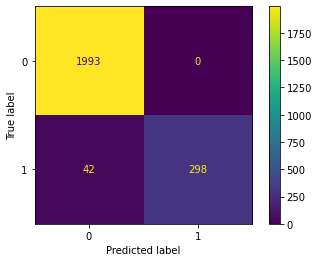

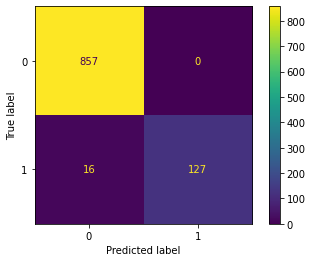

In [69]:
#y_preds= model_boost_gb.predict(X_test_scaled)
scores(model_boost_gb)

# Ensemble

In [70]:
voting_clf = VotingClassifier(estimators=[ 
                                          ("rf", rf_model) ,
                                          ('dt', best_DT_clf),
                                          ('xgb', xgb_model),
                                          ("gb", gb_m)], 
                                          voting= "soft")

In [71]:
voting_clf.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=10,
                                                     min_samples_split=7,
                                                     n_estimators=1150)),
                             ('dt',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=7,
                                                     min_samples_leaf=5,
                                                     min_samples_split=5)),
                             ('xgb',
                              XGBClassifier(alpha=1, base_score=0.5,
                                            booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample

In [72]:
#y_preds = voting_clf.predict(X_test_scaled)

Train Scores
log loss:  0.7402223830885283
accuracy:  0.9785683669095585
precision: 1.0
recall:    0.8529411764705882
Test Scores
log loss:  0.5526204223185719
accuracy:  0.984
precision: 1.0
recall:    0.8881118881118881


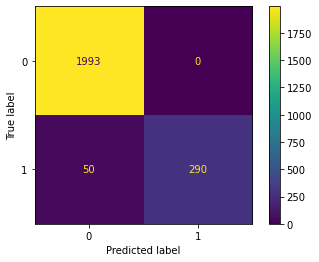

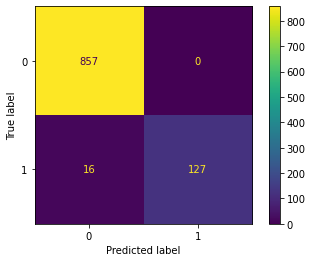

In [73]:
scores(voting_clf)

In [74]:
for clf in (rf_model, best_DT_clf, xgb_model, gb_m):
    clf.fit(X_train_scaled, y_train)
    y_pred= clf.predict(X_test_scaled)
    print(clf, recall_score(y_test, y_pred))

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=7,
                       n_estimators=1150) 0.7062937062937062
DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=5,
                       min_samples_split=5) 0.8881118881118881
XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.05, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0500000007, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:hinge', random_state=42, reg_alpha=1,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) 0.8881118881118881
GradientBoostingClassifier(random_state=42) 0.888111888

In [75]:
# plot_confusion_matrix(voting_clf, X_test_scaled, y_test)

Looks like the ensemble does the same however if we introduce unseen data having a ensemble may be to our advantage

# Recommendations

## Implementing Fixed Fee Plan

We know that total charge is one of the features of the dataset that has has high influence. To adjust total charge, we can modify the charge per minute feature. Instead of adjusting the charge per minute for all types of calls, which could lead to a greater loss in revenue, we focused on day calls because our preliminary EDA showed that the charge per min for day calls were very different between customers who churn and those who do not churn.

In [76]:
#create a new copy of the main data frame
new_df1 = df.copy()

In [77]:
#see the statistics for total day minutes and charge per min for day calls
new_df1[['total_day_minutes', 'charge_per_min_day']].describe()

,total_day_minutes,charge_per_min_day
count,3333.000000,3333.000000
mean,179.775098,0.318147
std,54.467389,0.124572
min,0.000000,0.000000
25%,143.700000,0.234490
50%,179.400000,0.304409
75%,216.400000,0.384510
max,350.800000,1.228000


In [78]:
#see the statistics for total day minutes and charge per min for day calls for those who churn
new_df1[new_df1['churn'] == 1][['total_day_minutes', 'charge_per_min_day']].describe()

,total_day_minutes,charge_per_min_day
count,483.000000,483.000000
mean,206.914079,0.364148
std,68.997792,0.158242
min,0.000000,0.000000
25%,153.250000,0.252803
50%,217.600000,0.348720
75%,265.950000,0.449143
max,350.800000,1.150000


In [79]:
#see the statistics for total day minutes and charge per min for day calls for those who do not churn
new_df1[new_df1['churn'] == 0][['total_day_minutes', 'charge_per_min_day']].describe()

,total_day_minutes,charge_per_min_day
count,2850.000000,2850.000000
mean,175.175754,0.310351
std,50.181655,0.116160
min,0.000000,0.000000
25%,142.825000,0.233230
50%,177.200000,0.299729
75%,210.300000,0.374728
max,315.600000,1.228000


<AxesSubplot:>

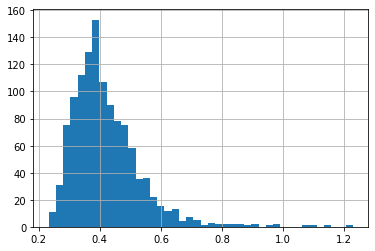

In [80]:
new_df1[new_df1['total_day_minutes'] > 200]['charge_per_min_day'].hist(bins='auto')

We see that the 50% percentile of total_day_minutes is ~200 minutes (we round down because if we were to promote this plan, we should have a rounded number) for customers who churn. We also see that the the price per minute at this percentile is ~$0.35. We suggest to implement a fixed fee plan for those who go over 200 minutes at a price of $0.35 per minute.

In [81]:
def fixed_day_plan(df, day_min, charge_min_day):
    '''
    this function modifies the dataframe to adjust the charge_min_day to a fixed rate
    given a threshold for total_day_min, and returns the modified df and churn rate
    '''
    df.loc[df['total_day_minutes'] > day_min, 'charge_per_min_day'] = charge_min_day
    df['total_day_charge'] = df['charge_per_min_day'] * df['total_day_minutes']
    df['total_charge_dom'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge']
    df['total_charge'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge'] + df['total_intl_charge']
    
    #seperating the target and data
    X = df.drop('churn', axis=1)
    y = df['churn']
    
    categorical = ['state','area_code', 'international_plan', 'voice_mail_plan', 'region']
    df_cat = X[categorical]
    df_cont = X.drop(categorical,axis = 1)
    
    #splitting the numericals and categoricals
    X_num = df_cont.columns
    X_cat = df_cat.columns
    
    #preprocessing the pipeline with standard scaler and one hot encoder
    numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
    catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                          sparse=False))
    ])

    pp = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
    ])
    
    # transform the pipeline and then converting it back into a dataframe
    X_scaled = pp.fit_transform(X)
    
    #aggregating col names from the one hot encode 
    cat_names = pp.transformers_[1][1].named_steps['ohe'].get_feature_names(X_cat).tolist()
    feature_names= list(X_num) + cat_names

    # renaming the data frame with corresponding col names
    X_scaled = pd.DataFrame(X_scaled, columns = feature_names)
    
    #Gradient Boost
    model_boost_gb = GradientBoostingClassifier(random_state=42)
    gb_m = model_boost_gb.fit(X_scaled,y)
    
    #predict the new churn from this dataframe
    df['churn'] = gb_m.predict(X_scaled)
    
    #calculate the new churn and total charge
    new_churn = round(df['churn'].value_counts(normalize=True)[1]*100, 2)
    
    return df, new_churn

In [82]:
new_df1, churn1 = fixed_day_plan(new_df1, 200, 0.35)
print(churn1)

12.57


## Improve Customer Satisfaction

<AxesSubplot:>

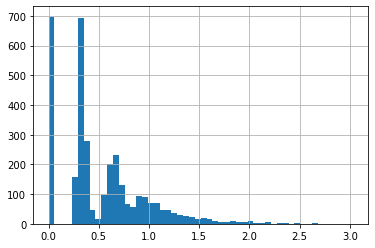

In [83]:
df['call_satisfaction'].hist(bins='auto')

In [84]:
df['call_satisfaction'].describe()

count    3333.000000
mean        0.519833
std         0.445629
min         0.000000
25%         0.289017
50%         0.366300
75%         0.727273
max         3.030303
Name: call_satisfaction, dtype: float64

In [85]:
new_df2 = new_df1.copy()

In [86]:
def call_satis(df, threshold, new_satis):
    df.loc[df['call_satisfaction'] > threshold, 'call_satisfaction'] = new_satis
    df['customer_service_calls'] = (df['call_satisfaction']/100)*df['total_calls']
    
    #seperating the target and data
    X = df.drop('churn', axis=1)
    y = df['churn']
    
    categorical = ['state','area_code', 'international_plan', 'voice_mail_plan', 'region']
    df_cat = X[categorical]
    df_cont = X.drop(categorical,axis = 1)
    
    #splitting the numericals and categoricals
    X_num = df_cont.columns
    X_cat = df_cat.columns
    
    #preprocessing the pipeline with standard scaler and one hot encoder
    numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
    catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                          sparse=False))
    ])

    pp = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
    ])
    
    # transform the pipeline and then converting it back into a dataframe
    X_scaled = pp.fit_transform(X)
    
    #aggregating col names from the one hot encode 
    cat_names = pp.transformers_[1][1].named_steps['ohe'].get_feature_names(X_cat).tolist()
    feature_names= list(X_num) + cat_names

    # renaming the data frame with corresponding col names
    X_scaled = pd.DataFrame(X_scaled, columns = feature_names)
    
    #Gradient Boost
    model_boost_gb = GradientBoostingClassifier(random_state=42)
    gb_m = model_boost_gb.fit(X_scaled,y)
    
    #predict the new churn from this dataframe
    df['churn'] = gb_m.predict(X_scaled)
    
    #calculate the new churn and total charge
    new_churn = round(df['churn'].value_counts(normalize=True)[1]*100, 2)
    
    return df, new_churn

In [87]:
new_df2, churn2 = call_satis(new_df2, 0.72, 0.72)
print(churn2)

10.23


## Prioritize Key States

In [88]:
new_df3 = new_df2.copy()

In [89]:
key_states = ['NJ', 'CA', 'TX', 'MD', 'SC']

In [90]:
def state_churn(df, state):
    new_df = df[df['state'] == state]
    churn = round(new_df['churn'].value_counts(normalize=True)[1]*100, 0)
    return churn

In [91]:
states = {}
for state in key_states:
    states[state] = [None, None]

for state in key_states:
    states[state][0] = state_churn(new_df3, state)
    states[state][1] = state_churn(new_df3, state)

In [92]:
states

{'NJ': [21.0, 21.0],
 'CA': [18.0, 18.0],
 'TX': [15.0, 15.0],
 'MD': [20.0, 20.0],
 'SC': [13.0, 13.0]}

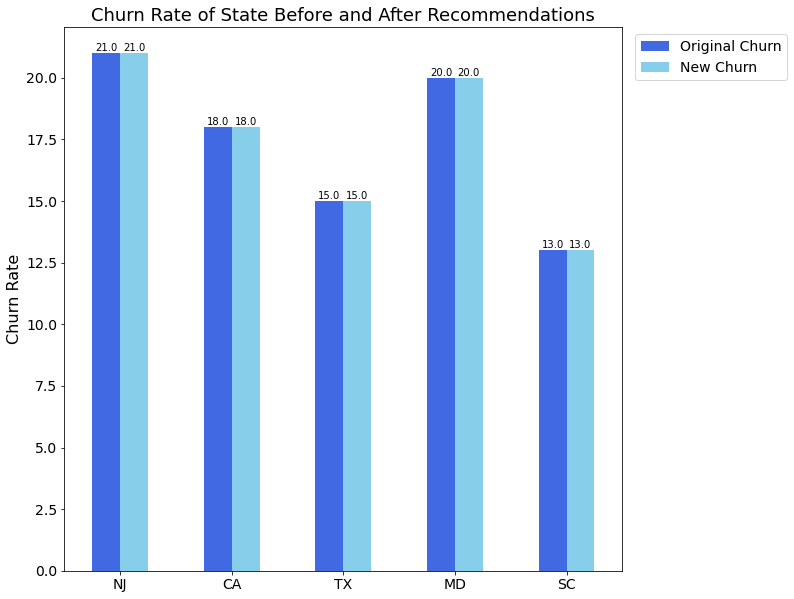

In [93]:
df = pd.DataFrame(states).T
df.rename(columns={0:'Original Churn', 1: 'New Churn'}, inplace=True)
# plot grouped bar chart
fig, ax = plt.subplots(figsize=(10,10))

df.plot(kind="bar", ax=ax, color=['royalblue','skyblue'])

#set labels for axes, and the x and y tick size
ax.set_title('Churn Rate of State Before and After Recommendations', fontsize=18)
ax.set_ylabel("Churn Rate", fontsize=16)
plt.xticks(size = 14, rotation=0)
plt.yticks(size = 14)
    
#reverse the legend labels so that it matches with the bar graphs
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', prop={'size': 14})


for bar in ax.patches:
    # The text annotation for each bar should be its height
    bar_value = bar.get_height()
    text = f'{bar_value:,}'
    # Get the middle of each bar on the x-axis.
    text_x = bar.get_x() + bar.get_width() / 2
    # get_y() is where the bar starts so we add the height to it.
    text_y = bar.get_y() + bar_value
    # set the text
    ax.text(text_x, text_y, text, ha='center', va='bottom', color='black', size=10)
    
fig.savefig('images/Churn_Rate_of_State_Before_and_After_Recommendations.png', bbox_inches='tight')

# Let's create a function to calculate percentage of a customer churning

In [94]:
df

,Original Churn,New Churn
NJ,21.0,21.0
CA,18.0,18.0
TX,15.0,15.0
MD,20.0,20.0
SC,13.0,13.0


In [95]:
# single customer churning probability calculator

def churn(total_day_minutes, total_charge, customer_service_calls, international_plan):
    
    #using the ensemble to predict
    voting_clf = VotingClassifier(estimators=[ 
                                          ("rf", rf_model) ,
                                          ('dt', best_DT_clf),
                                          ('xgb', xgb_model),
                                          ("gb", gb_m)], 
                                          voting= "soft")
    
    #slice out corresponding df
    data= df[['total_day_minutes', 'total_charge', 
            'customer_service_calls','international_plan','churn'
              ]]
    
    
    #split into train test
    y= data['churn']
    X= data.drop('churn', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3 ,random_state=42)
    
    
    #pipeline reintroduced to fit specific data frame
    
    X_num=X_train.columns[:3]
    X_cat=X_train.columns[3:4]
    
    numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
    catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                          sparse=False))
    ])

    pp = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
    ])
    
    
    #use pipeline to scale 
    X_train_scaled = pp.fit_transform(X_train)
    X_test_scaled= pp.transform(X_test)
    X_train_scaled= pd.DataFrame(X_train_scaled)
    X_test_scaled=pd.DataFrame(X_test_scaled)
    
#     create a single entry from function inputs to test
    d= {'total_day_minutes':total_day_minutes , 
        'total_charge': total_charge , 
        'customer_service_calls': customer_service_calls,
        'international_plan':international_plan}
    
    df_pred= pd.DataFrame(d, index=[0])
    
    #scale it so model doesnt break on string entries
    df_pred = pp.transform(df_pred)
    df_pred = pd.DataFrame(df_pred)
    
    #fit the model
    voting_clf.fit(X_train_scaled, y_train)
  
    #predict the probability that customer may churn
    p = voting_clf.predict_proba(df_pred)
    
#    
    
    print(f"The selected account has a {round(p[0][1]*100)}% chance of churning ")
    

In [96]:
churn(200,34,0,"yes")

KeyError: "None of [Index(['total_day_minutes', 'total_charge', 'customer_service_calls',\n       'international_plan', 'churn'],\n      dtype='object')] are in the [columns]"

In [ ]:
# example used for one customer
churn(128,75.56,1,"no")

In [ ]:
df.loc[193]

In [ ]:
churn(94,51.02,0,"no")

In [ ]:
df.head(20)

In [ ]:
df2= df.head(20)

In [ ]:
df2

In [ ]:
a=[]
for index, i in df2.iterrows():
    result = churn(i['account_length'], i['total_charge'], i['customer_service_calls'], i['international_plan'])
    a.append(result)
#     print(i)

In [ ]:
a

In [ ]:
b= df.loc[:19, "churn"]==a

In [ ]:
b

In [ ]:
df.loc[(df['churn']==1),"total_charge"].avg()

In [ ]:
df.loc[(df['churn']==1),"total_charge"]